In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install --pre --index-url https://download.pytorch.org/whl/nightly/cu128 torch torchvision torchaudio
!pip install "momentfm==0.1.4"
!pip install "pandas<3" "scipy<1.14" matplotlib



Found existing installation: torch 2.11.0.dev20260201+cu128
Uninstalling torch-2.11.0.dev20260201+cu128:
  Successfully uninstalled torch-2.11.0.dev20260201+cu128
Found existing installation: torchvision 0.25.0.dev20260201+cu128
Uninstalling torchvision-0.25.0.dev20260201+cu128:
  Successfully uninstalled torchvision-0.25.0.dev20260201+cu128
Found existing installation: torchaudio 2.11.0.dev20260201+cu128
Uninstalling torchaudio-2.11.0.dev20260201+cu128:
  Successfully uninstalled torchaudio-2.11.0.dev20260201+cu128
Looking in indexes: https://download.pytorch.org/whl/nightly/cu128
  Using cached https://download.pytorch.org/whl/nightly/cu128/torch-2.11.0.dev20260201%2Bcu128-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached https://download.pytorch.org/whl/nightly/cu128/torchvision-0.25.0.dev20260201%2Bcu128-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached https://download.pytorch.org/whl/nightly/cu128/torchaudio-2.11.0.dev20260201%2Bcu128-cp31

In [2]:
import os
import sys
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.signal.windows import triang

import torch
print("torch:", torch.__version__)
print("cuda runtime:", torch.version.cuda)
print("device:", torch.cuda.get_device_name(0))
print("capability:", torch.cuda.get_device_capability(0))

from momentfm import MOMENTPipeline

from finetune import finetune_reflectance



torch: 2.11.0.dev20260201+cu128
cuda runtime: 12.8
device: NVIDIA RTX PRO 6000 Blackwell Server Edition
capability: (12, 0)


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
df = pd.read_csv("processed_reflectance.csv")
df_all = df.sort_values("timestamp").reset_index(drop=True)

spec_cols = [c for c in df_all.columns if c != "timestamp"]

In [4]:
def plot_reflectance_heatmap(df, spectral_prefix="", 
                             wl_start=400, cmap="RdYlGn",
                             vmin=-0.075, vmax=0.275,
                             title="Reflectance Variation Over Time",
                             figsize=(10,7)):
    """
    Plot time × wavelength reflectance heatmap.
    df must contain a 'timestamp' column and spectral_bin_* columns.
    """

    if "timestamp" not in df.columns:
        raise ValueError("DataFrame must contain a 'timestamp' column.")

    # Spectral columns
    spec_cols = [c for c in df.columns if c != "timestamp"]
    if len(spec_cols) == 0:
        raise ValueError(f"No columns starting with '{spectral_prefix}' found.")

    # Convert values → matrix
    data = df[spec_cols].to_numpy()

    # Wavelength axis
    wl_end = wl_start + len(spec_cols) - 1
    wavelengths = np.arange(wl_start, wl_end + 1)

    # Date labels
    dates = pd.to_datetime(df["timestamp"]).dt.strftime("%Y-%m-%d")

    # Plot
    plt.figure(figsize=figsize)

    plt.imshow(
        data,
        aspect='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=[wavelengths[0], wavelengths[-1], len(df), 0],
        origin='upper'      # time runs from top to bottom
    )

    plt.colorbar(label="Reflectance")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Date")
    plt.title(title, fontsize=14)

    # Y-ticks → readable dates
    yticks = np.linspace(0, len(df)-1, 10).astype(int)
    plt.yticks(yticks, dates.iloc[yticks], rotation=0)

    plt.tight_layout()
    plt.show()

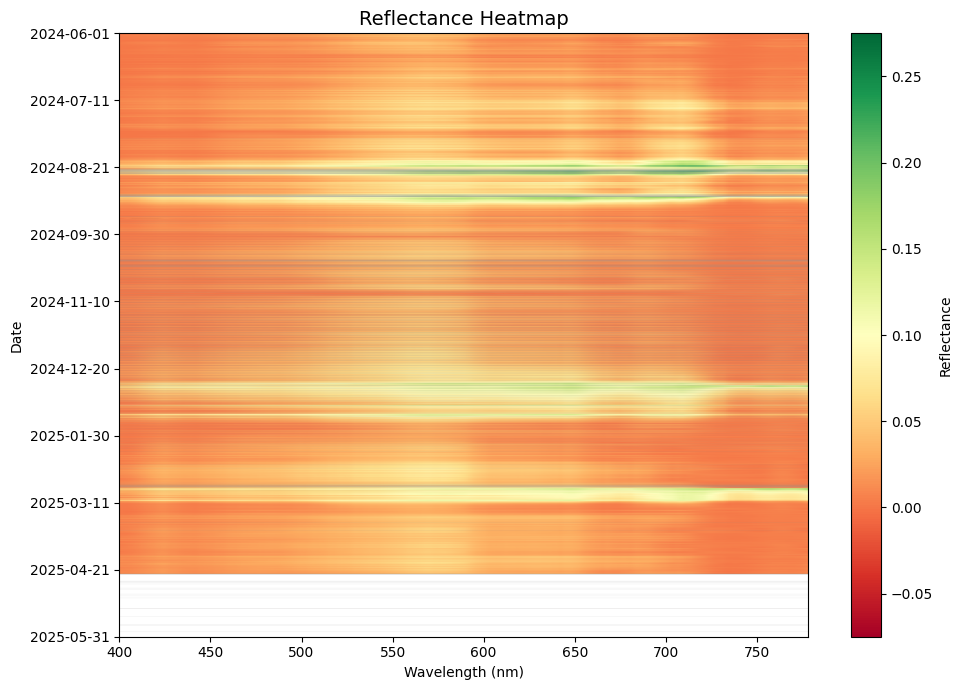

In [5]:
plot_reflectance_heatmap(
    df_all,
    title="Reflectance Heatmap",
)

In [6]:
def interpolate_spectrum_fill_all(y, smooth=True, window=15, poly=3):
    """
    y: 1D array of shape (n_wavelengths,), may contain np.nan.
    Fills *all* gaps (NaNs) in a partially valid spectrum.

    - uses linear interpolation along wavelength
    - extrapolates edges with nearest valid value
    - optional Savitzky–Golay smoothing on the filled curve
    """
    y = y.astype(float)
    x = np.arange(len(y))

    mask = ~np.isnan(y)
    n_valid = mask.sum()

    # No or almost no information → return as is (still NaN)
    if n_valid < 2:
        return y

    x_valid = x[mask]
    y_valid = y[mask]

    # Linear interpolation + edge extrapolation
    # np.interp fills interior by interpolation and outside with boundary values
    y_filled = np.interp(x, x_valid, y_valid)

    if smooth:
        # apply gentle smoothing on the fully filled curve
        if len(y_filled) >= window:
            y_smooth = savgol_filter(y_filled, window_length=window, polyorder=poly)
            return y_smooth
        else:
            # not enough points for this window length
            return y_filled

    return y_filled

# df: your original DataFrame
# spec_cols: list of spectral_bin_* columns, e.g.:
# spec_cols = [c for c in df.columns if c.startswith("spectral_bin_")]

df_processed = df.copy()

is_fully_nan = df_processed[spec_cols].isna().all(axis=1)
is_partially_nan = df_processed[spec_cols].isna().any(axis=1) & ~is_fully_nan

rows_to_work_on = df_processed[is_partially_nan].index

for idx in rows_to_work_on:
    row = df_processed.loc[idx, spec_cols].to_numpy(dtype=float)

    # fill all gaps in that row across all bins
    row_filled = interpolate_spectrum_fill_all(
        row,
        smooth=True,   # set to False if you don’t want smoothing
        window=15,
        poly=3
    )

    df_processed.loc[idx, spec_cols] = row_filled

print("Per-row interpolation complete (all gaps filled in partial rows).")

# Keep fully-NaN rows as they are
df_ready_for_moment = df_processed.sort_values("timestamp").reset_index(drop=True)

print("\nData is now ready.")
print(f"Total rows: {len(df_ready_for_moment)}")
print(
    "Rows with full gaps (still NaN):",
    df_ready_for_moment[spec_cols].isna().all(axis=1).sum()
)

df = df_ready_for_moment.copy()
df

Per-row interpolation complete (all gaps filled in partial rows).

Data is now ready.
Total rows: 16425
Rows with full gaps (still NaN): 2059


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2024-06-01 07:00:00+07:00,0.001080,0.000751,0.000507,0.000341,0.000246,0.000217,0.000249,0.000334,0.000466,...,0.005438,0.005187,0.004836,0.004382,0.003819,0.003146,0.002357,0.001449,0.000418,-0.000740
1,2024-06-01 07:15:00+07:00,0.000549,0.000239,0.000008,-0.000149,-0.000238,-0.000264,-0.000233,-0.000150,-0.000021,...,0.004390,0.004019,0.003586,0.003093,0.002546,0.001947,0.001301,0.000610,-0.000121,-0.000890
2,2024-06-01 07:30:00+07:00,0.001223,0.001235,0.001246,0.001254,0.001261,0.001265,0.001268,0.001270,0.001269,...,0.006886,0.006880,0.006877,0.006877,0.006881,0.006889,0.006901,0.006917,0.006937,0.006961
3,2024-06-01 07:45:00+07:00,0.000463,0.000454,0.000445,0.000438,0.000431,0.000426,0.000422,0.000420,0.000420,...,0.003022,0.002646,0.002314,0.002047,0.001863,0.001783,0.001825,0.002008,0.002354,0.002880
4,2024-06-01 08:00:00+07:00,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002949,0.003204,0.003517,0.003893,0.004338,0.004856,0.005452,0.006133,0.006903,0.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16420,2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16421,2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16422,2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16423,2025-05-31 17:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


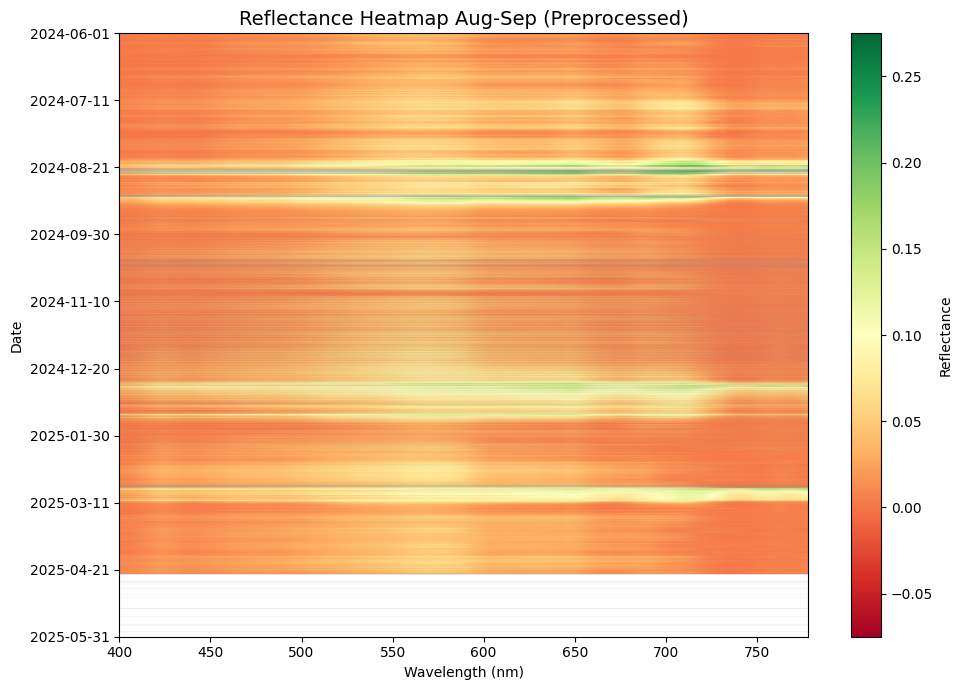

In [7]:
plot_reflectance_heatmap(
    df,
    title="Reflectance Heatmap Aug-Sep (Preprocessed)",
)

In [8]:
df = df_ready_for_moment.copy()
spec_cols = [c for c in df.columns if c != "timestamp"]

print("rows:", len(df), "features:", len(spec_cols))
print("fully-NaN rows:", df[spec_cols].isna().all(axis=1).sum())
print("any-NaN rows:", df[spec_cols].isna().any(axis=1).sum())

valid = ~df[spec_cols].isna().any(axis=1)
runs = (valid != valid.shift()).cumsum()
max_run = valid.groupby(runs).sum().max()

print("Longest contiguous fully-valid run:", int(max_run))

df = df_ready_for_moment.copy()
spec_cols = [c for c in df.columns if c != "timestamp"]

# keep ONLY rows that have no NaNs across spectrum
df_train = df.loc[~df[spec_cols].isna().any(axis=1)].reset_index(drop=True)

print("train rows:", len(df_train))

df_train

rows: 16425 features: 379
fully-NaN rows: 2059
any-NaN rows: 2059
Longest contiguous fully-valid run: 2881
train rows: 14366


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2024-06-01 07:00:00+07:00,0.001080,0.000751,0.000507,0.000341,0.000246,0.000217,0.000249,0.000334,0.000466,...,0.005438,0.005187,0.004836,0.004382,0.003819,0.003146,0.002357,0.001449,0.000418,-0.000740
1,2024-06-01 07:15:00+07:00,0.000549,0.000239,0.000008,-0.000149,-0.000238,-0.000264,-0.000233,-0.000150,-0.000021,...,0.004390,0.004019,0.003586,0.003093,0.002546,0.001947,0.001301,0.000610,-0.000121,-0.000890
2,2024-06-01 07:30:00+07:00,0.001223,0.001235,0.001246,0.001254,0.001261,0.001265,0.001268,0.001270,0.001269,...,0.006886,0.006880,0.006877,0.006877,0.006881,0.006889,0.006901,0.006917,0.006937,0.006961
3,2024-06-01 07:45:00+07:00,0.000463,0.000454,0.000445,0.000438,0.000431,0.000426,0.000422,0.000420,0.000420,...,0.003022,0.002646,0.002314,0.002047,0.001863,0.001783,0.001825,0.002008,0.002354,0.002880
4,2024-06-01 08:00:00+07:00,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002949,0.003204,0.003517,0.003893,0.004338,0.004856,0.005452,0.006133,0.006903,0.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14361,2025-05-14 16:45:00+07:00,0.004920,0.004837,0.004746,0.004653,0.004565,0.004488,0.004426,0.004388,0.004378,...,0.006922,0.006949,0.006993,0.007057,0.007145,0.007258,0.007401,0.007576,0.007785,0.008033
14362,2025-05-19 14:30:00+07:00,0.011706,0.011558,0.011419,0.011294,0.011186,0.011098,0.011034,0.010996,0.010989,...,0.007035,0.007026,0.007032,0.007058,0.007107,0.007182,0.007288,0.007427,0.007605,0.007824
14363,2025-05-24 13:45:00+07:00,0.017234,0.016427,0.015758,0.015224,0.014821,0.014548,0.014400,0.014374,0.014468,...,0.004604,0.004933,0.005425,0.006096,0.006964,0.008043,0.009350,0.010901,0.012711,0.014799
14364,2025-05-24 17:45:00+07:00,0.015856,0.014513,0.013369,0.012417,0.011650,0.011063,0.010647,0.010396,0.010303,...,0.004851,0.004594,0.004326,0.004058,0.003800,0.003564,0.003361,0.003201,0.003095,0.003055


In [9]:
# Your df_ready_for_moment is already created from the previous step.
SEQ_LEN = 512       # Window size for the model. 512 is a good default for MOMENT.
NUM_EPOCHS = 5      # Number of times to loop through the data. Start with 5-10.
OUTPUT_DIR = "finetuned_model"

# Run the fine-tuning process
print("\nStarting model fine-tuning...")
finetuned_model = finetune_reflectance(
    seq_len=SEQ_LEN, 
    num_epochs=NUM_EPOCHS, 
    input_dataframe=df_train  # <-- Here is where you use your dataframe
)
print("Fine-tuning complete.")

# Step 3: Save Your New, Specialized Model
os.makedirs(OUTPUT_DIR, exist_ok=True)
model_save_path = os.path.join(OUTPUT_DIR, f"reflectance_imputer_epoch_{NUM_EPOCHS}.pt")
torch.save(finetuned_model.state_dict(), model_save_path)

print(f"\nYour fine-tuned model has been saved to: {model_save_path}")


Starting model fine-tuning...
Using device: cuda
Starting fine-tuning... Train batches: 4, Val batches: 1


Epoch 1 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 1: Train Loss = 0.000200, Val Loss = 0.000069


Epoch 2 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 2: Train Loss = 0.000193, Val Loss = 0.000070


Epoch 3 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 3: Train Loss = 0.000190, Val Loss = 0.000069


Epoch 4 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 4: Train Loss = 0.000198, Val Loss = 0.000069


Epoch 5 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 5: Train Loss = 0.000208, Val Loss = 0.000069
Fine-tuning complete.

Your fine-tuned model has been saved to: finetuned_model/reflectance_imputer_epoch_5.pt


In [10]:
# ----------------------------
# Config
# ----------------------------
MODEL_PATH = "finetuned_model/reflectance_imputer_epoch_5.pt"
BASE_MODEL = "AutonLab/MOMENT-1-large"

WIN = 512
STRIDE = WIN // 2
BATCH_WINDOWS = 4   # number of time windows per batch (adjust up if you have VRAM)
APPLY_CLIP = False  # set True if you are 100% sure reflectance cannot be negative

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0), "cap:", torch.cuda.get_device_capability(0))

# ----------------------------
# Load model ONCE
# ----------------------------
gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

inference_model = MOMENTPipeline.from_pretrained(BASE_MODEL)
state = torch.load(MODEL_PATH, map_location="cpu")
missing, unexpected = inference_model.load_state_dict(state, strict=False)
print("Loaded weights. Missing keys:", len(missing), "Unexpected keys:", len(unexpected))

inference_model = inference_model.to(device).float().eval()
torch.set_grad_enabled(False)

# ----------------------------
# Prepare data
# ----------------------------
df = df_ready_for_moment.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp")

spec_cols = [c for c in df.columns if c != "timestamp"]
T = len(df)
F = len(spec_cols)

print("rows:", T, "features:", F)
X_spec = df[spec_cols].values.astype(np.float32)

# mask_spec: True where missing
mask_spec = np.isnan(X_spec)
fully_missing_rows = mask_spec.all(axis=1)
print("Fully-missing rows:", int(fully_missing_rows.sum()))
print("Any-missing rows:", int(mask_spec.any(axis=1).sum()))

# Fill NaNs with 0 for the encoder input (mask tells the model what is missing)
X_fill = np.nan_to_num(X_spec, nan=0.0).astype(np.float32)

# ----------------------------
# Window coverage + padding
# ----------------------------
win = min(WIN, T)              # if dataset is shorter than 512, shrink window
stride = max(1, min(STRIDE, win // 2))

# pad so we can slide neatly
if T < win:
    # should not happen because win = min(WIN, T), but kept for safety
    pad_len = win - T
else:
    # for stitching we want starts stepping by stride until last window
    # padding helps if last segment doesn't align with stride
    remainder = (T - win) % stride
    pad_len = 0 if remainder == 0 else (stride - remainder)

X_fill_padded = np.pad(X_fill, ((0, pad_len), (0, 0)), mode="constant", constant_values=0)
mask_spec_padded = np.pad(mask_spec, ((0, pad_len), (0, 0)), mode="constant", constant_values=True)

T_padded = X_fill_padded.shape[0]

# starts with guaranteed last start included
starts = list(np.arange(0, max(1, T_padded - win + 1), stride))
last_start = T_padded - win
if starts[-1] != last_start:
    starts.append(last_start)
starts = np.array(sorted(set(starts)), dtype=int)

print("win:", win, "stride:", stride, "pad_len:", pad_len, "num_windows:", len(starts))

# ----------------------------
# Stitching buffers
# ----------------------------
stitch_w = triang(win).astype(np.float32).reshape(-1, 1)  # (win, 1)
imputed_padded = np.zeros_like(X_fill_padded, dtype=np.float32)
counts = np.zeros_like(X_fill_padded, dtype=np.float32)

# ----------------------------
# Inference loop (batched by windows)
# ----------------------------
for i in range(0, len(starts), BATCH_WINDOWS):
    batch_starts = starts[i:i + BATCH_WINDOWS]

    # Build batch: stacked features for each window
    # x_enc shape = (B*F, 1, win)
    Xs = []
    Ms = []
    for s in batch_starts:
        seg = X_fill_padded[s:s+win, :].T.astype(np.float32)          # (F, win)
        mseg = (~mask_spec_padded[s:s+win, :]).T.astype(np.int64)     # (F, win) 1=observed,0=missing
        Xs.append(seg[:, None, :])                                    # (F, 1, win)
        Ms.append(mseg)

    X_batch = np.concatenate(Xs, axis=0)                              # (B*F, 1, win)
    M_batch = np.concatenate(Ms, axis=0)                              # (B*F, win)

    x_enc = torch.from_numpy(X_batch).to(device, non_blocking=True)
    input_mask = torch.from_numpy(M_batch).to(device, non_blocking=True)

    out = inference_model(x_enc=x_enc, input_mask=input_mask)
    recon = out.reconstruction.detach().float().cpu().numpy().squeeze(1)  # (B*F, win)

    # Stitch each window back into time×features
    ptr = 0
    for s in batch_starts:
        block = recon[ptr:ptr+F, :].T                                  # (win, F)
        imputed_padded[s:s+win, :] += block * stitch_w
        counts[s:s+win, :] += stitch_w
        ptr += F

    # free GPU memory
    del x_enc, input_mask, out
    if device.type == "cuda":
        torch.cuda.empty_cache()

# finalize stitched reconstruction
imputed_padded = imputed_padded / (counts + 1e-8)
imputed = imputed_padded[:T, :]  # remove padding

# ----------------------------
# Fill only missing entries
# ----------------------------
filled = X_spec.copy()
filled[mask_spec] = imputed[mask_spec]

# Optional clipping (OFF by default)
if APPLY_CLIP:
    filled = np.clip(filled, 0, None)

df_final_imputed = df.copy()
df_final_imputed[spec_cols] = filled

print("\nImputation complete.")
print("Remaining fully-missing rows:",
      int(df_final_imputed[spec_cols].isna().all(axis=1).sum()))
print("Total NaNs remaining:",
      int(df_final_imputed[spec_cols].isna().sum().sum()))

# ----------------------------
# Diagnostics: did the missing month get covered/predicted?
# ----------------------------
fully_missing_idx = np.where(fully_missing_rows)[0]
if len(fully_missing_idx) > 0:
    cov = counts[:T, :][fully_missing_idx]
    print("Coverage on fully-missing rows (counts): mean/min/max =",
          float(cov.mean()), float(cov.min()), float(cov.max()))
    print("Mean abs imputed on fully-missing rows:",
          float(np.abs(imputed[fully_missing_idx]).mean()))


Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Server Edition cap: (12, 0)
Loaded weights. Missing keys: 0 Unexpected keys: 0
rows: 16425 features: 379
Fully-missing rows: 2059
Any-missing rows: 2059
win: 512 stride: 256 pad_len: 215 num_windows: 64

Imputation complete.
Remaining fully-missing rows: 1562
Total NaNs remaining: 591998
Coverage on fully-missing rows (counts): mean/min/max = 0.9984054565429688 0.841796875 1.0
Mean abs imputed on fully-missing rows: nan


In [11]:
df_final_imputed[spec_cols].isna().sum().sum()
df_final_imputed

,400,401,402,403,404,405,406,407,408,409,...,769,770,771,772,773,774,775,776,777,778
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-06-01 07:00:00+07:00,0.001080,0.000751,0.000507,0.000341,0.000246,0.000217,0.000249,0.000334,0.000466,0.000640,...,0.005438,0.005187,0.004836,0.004382,0.003819,0.003146,0.002357,0.001449,0.000418,-0.000740
2024-06-01 07:15:00+07:00,0.000549,0.000239,0.000008,-0.000149,-0.000238,-0.000264,-0.000233,-0.000150,-0.000021,0.000148,...,0.004390,0.004019,0.003586,0.003093,0.002546,0.001947,0.001301,0.000610,-0.000121,-0.000890
2024-06-01 07:30:00+07:00,0.001223,0.001235,0.001246,0.001254,0.001261,0.001265,0.001268,0.001270,0.001269,0.001267,...,0.006886,0.006880,0.006877,0.006877,0.006881,0.006889,0.006901,0.006917,0.006937,0.006961
2024-06-01 07:45:00+07:00,0.000463,0.000454,0.000445,0.000438,0.000431,0.000426,0.000422,0.000420,0.000420,0.000422,...,0.003022,0.002646,0.002314,0.002047,0.001863,0.001783,0.001825,0.002008,0.002354,0.002880
2024-06-01 08:00:00+07:00,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002949,0.003204,0.003517,0.003893,0.004338,0.004856,0.005452,0.006133,0.006903,0.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


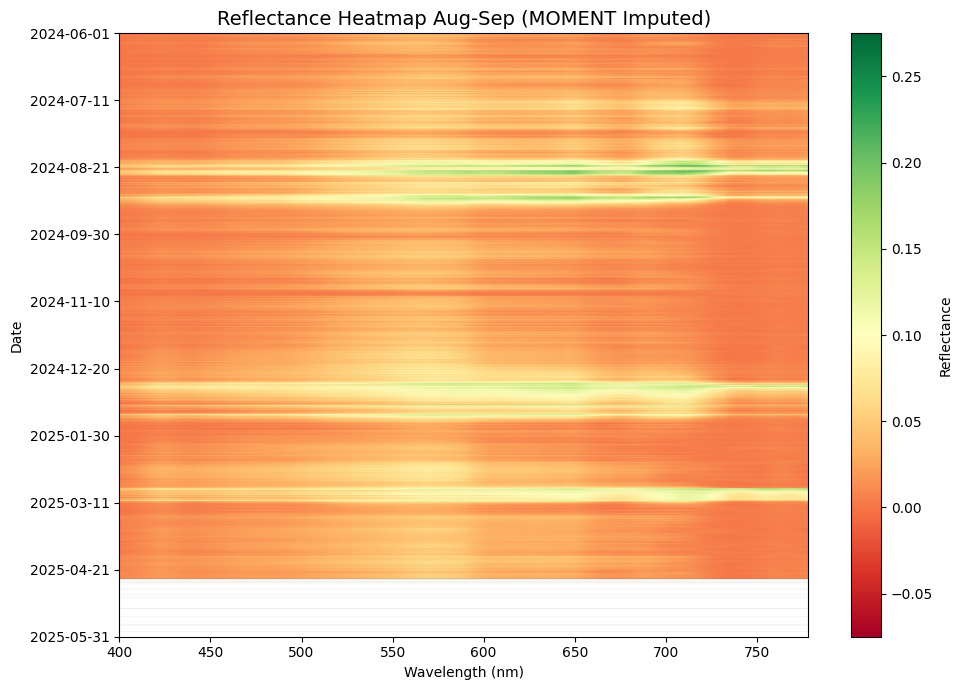

In [12]:
df_final_imputed = df_final_imputed.reset_index()
plot_reflectance_heatmap(
    df_final_imputed,
    title="Reflectance Heatmap Aug-Sep (MOMENT Imputed)",
)

In [13]:
df_final_imputed.to_csv("imputed_MOMENT_with_finetune.csv", index=False)